## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [ ]:
import numpy as np
# import these modules
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load dataset

In [ ]:
emails = []
labels = []
f = open("./emails.txt", 'r')
for line in f.readlines():
    line = line.strip()
    email = " ".join(line.split()[1:])
    # print(email)
    emails.append(email)
    label = line.split()[0]
    if label == 'ham':
        labels.append(0)
    else:
        labels.append(1)
print(len(emails))
original_emails = []
original_emails[:] = emails

5574


### Preprocess data

In [ ]:
# stem, lemmatize, replace email, url of each email

def preprocess(emails):

    stemmed_emails = []

    for email in emails:
        
        email = email.strip()
        
        email = ' '.join(re.split("[^A-Za-z0-9]" , email))  

        email = re.sub(r'[\s]+' , ' ', email)
        email = email.strip()

        # replace email with email-tag
        email = re.sub('\S+@\S+' , 'EMAILTOKEN' , email)

        # replace url with url-tag
        email = re.sub(r'https?:\/\/\S+' , 'url-tag' , email)

        # remove stopwords
        word_tokens = word_tokenize(email)
        stop_words = stopwords.words("english")
        email = [w.lower() for w in word_tokens if not w.lower() in stop_words]
        # remove punctuation

        ps = PorterStemmer()
        stemmed_email = []
        for w in email:
            stemmed_email.append(ps.stem(w))

        stemmed_emails.append(stemmed_email)
        
    return stemmed_emails


In [ ]:
emails = preprocess(emails)

### Computing TF-IDF Scores

In [ ]:
terms = {}

for email_idx,email in enumerate(emails):
    for term in email:
        try:
         terms[term][email_idx] += 1
        except:
            try:
                terms[term][email_idx] = 1
            except:
                terms[term] = {}
                terms[term][email_idx] = 1
# term_dict: {email id: count, email id: count}
# for each email run through all the terms - log(terms[term][docid]) * log(N/len(term_dict) + 1)

In [ ]:
terms_index = {}
for idx,term in enumerate(list(terms.keys())):
    terms_index[term] = idx

In [ ]:
# run this after you compute tfidf dictionary - changes variable email
emails_docid = []
for email_idx,email in enumerate(emails):
    emails_docid.append((email_idx,email))
emails[:] = emails_docid

In [ ]:
terms['0']

{1778: 1, 4725: 1, 4735: 1, 4841: 1}

In [ ]:
# initialize to 0
# tf_idf = []
# tf_idf_idx = []

# tf_idf = [[0.0]*len(list(terms.keys())) for i in range(len(emails))]
tf_idf = np.zeros(shape = (len(emails), len(terms)))

for email_idx,email in enumerate(emails):
    print(email_idx)
    for word in email[1]:
        # try:
        tf_idf[email_idx][terms_index[str(word)]] = np.log (terms[str(word)][email_idx] + 1) *  np.log( len(emails)/ (len(terms[str(word)]))  )
        # except: pass
    # tf_idf_idx.append((email_idx,tf_idf[email_idx]))

### Split data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(tf_idf, labels, test_size=0.4, random_state=42)
X_val , X_test , y_val , y_test = train_test_split(X_temp , y_temp , test_size=0.5 , random_state=42)

In [ ]:
len(X_train)

3344

In [ ]:
len(X_train)
len(X_val)

1115

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

In [111]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

def neighbours(test_email, x_train, y_train, k_value,distance='COSINE'):

    distances = []
    for train_idx,train_email in enumerate(x_train):

        vec1 = test_email.reshape(1,-1)
        vec2 = train_email.reshape(1,-1)

        if distance == 'COSINE':
            distances.append( (train_idx,cosine_similarity(vec1, vec2)))

        elif distance == 'EUCLIDEAN':
            distances.append( (train_idx,euclidean_distances(vec1,vec2)))

        elif distance == 'MANHATTAN':
            distances.append( (train_idx,manhattan_distances(vec1,vec2)))
    
    if distance == 'COSINE':
        distances.sort(key = lambda x: x[1],reverse=True)
    else:
        distances.sort(key = lambda x: x[1])

    neighbours = [(y_train[t[0]]) for t in distances]
    # print("cos sim: ",cosine_sim[:k_value])
    # print("in neighbours: ", neighbours)
    return neighbours

In [ ]:
neighbours(X_test[0], X_train, y_train, 5)

[0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(test_outputs,labels,k, similarity_measure):

    if similarity_measure != "SKLEARN_CLASSIFIER":
      true_labels = [labels[i[0]] for i in test_outputs]
      predictions = [i[1] for i in test_outputs]
    else:
      true_labels = test_outputs
      predictions = labels

    print(f"For k={k} and similarity measure {similarity_measure}")
    print("Accuracy score: ",accuracy_score(true_labels, predictions))

    print("F1 score: ", f1_score(true_labels,predictions))
    print("Precision score: ", precision_score(true_labels,predictions))
    print("Recall score: ", recall_score(true_labels,predictions))

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(true_labels,predictions))
    plt.title(all_sample_title, size = 15);
        
    # return precision, recall, f1, accuracy

In [89]:
import tqdm.notebook as tq
def train_model(train, y_train, test, k_value,distance="COSINE", check_hyper_parameters=False):

    test_outputs = []
    all_neighbours = []

    for test_idx,test_email in tq.tqdm(enumerate(test),total=len(test)):
        
        neighbour_labels = neighbours(test_email,train,y_train, k_value, distance)
        
        if check_hyper_parameters is True: 
          all_neighbours.append(neighbour_labels)

        neighbour_labels = neighbour_labels[:k_value]

        # getting majority label of top k neighbours
        if neighbour_labels.count(1) >= neighbour_labels.count(0):
            test_outputs.append((test_idx,1))
            # print("spam")
        else:
            test_outputs.append((test_idx,0))
            # print("ham")

        # print("\ntest email: ", original_emails[test_email[0]])

        # for t in top_k:
        #     print(original_emails[t[0]])
        
    # evaluate_model(test_outputs,labels)

    if check_hyper_parameters is True: return all_neighbours

    return test_outputs

# ***1. Experiment with different distance measures [Euclidean distance, Manhattan distance] and compare with the Cosine Similarity distance results.***

## K=5,Cosine

In [ ]:
test_outputs = train_model(X_train, y_train, X_val, 5)

For k=5 and similarity measure COSINE
Accuracy score:  0.9668161434977578
F1 score:  0.8560311284046692
Precision score:  0.9821428571428571
Recall score:  0.7586206896551724


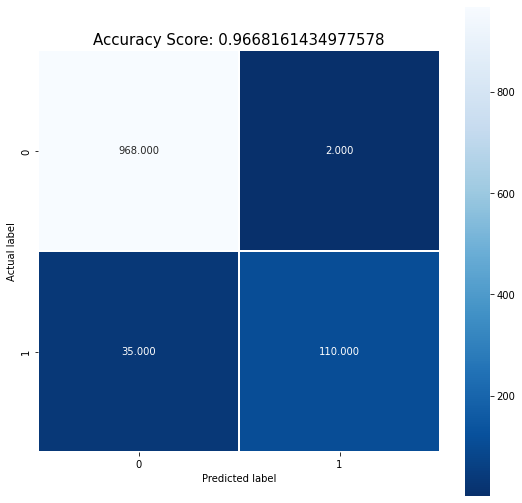

In [ ]:
evaluate_model(test_outputs,y_val,5,"COSINE")

## K=5, Euclidean

In [ ]:
test_euc_outputs = train_model(X_train, y_train, X_val, 5, "EUCLIDEAN")

  0%|          | 0/1115 [00:00<?, ?it/s]

For k=5 and similarity measure EUCLIDEAN
Accuracy score:  0.8869955156950673
F1 score:  0.23170731707317074
Precision score:  1.0
Recall score:  0.1310344827586207


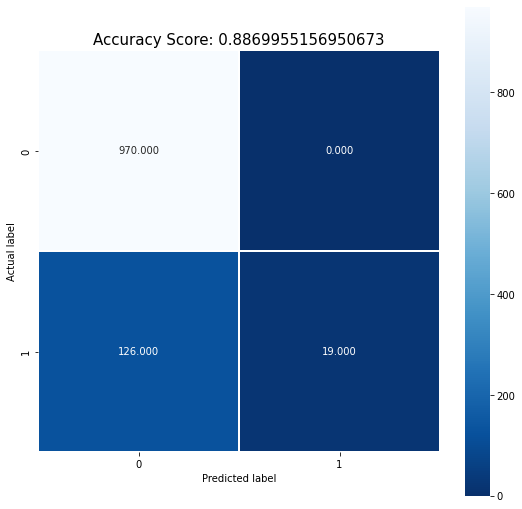

In [ ]:
evaluate_model(test_euc_outputs,y_val,5,"EUCLIDEAN")

## K=5, Manhattan

In [ ]:
test_man_outputs = train_model(X_train, y_train, X_val, 5, "MANHATTAN")

  0%|          | 0/1115 [00:00<?, ?it/s]

For k=5 and similarity measure MANHATTAN
Accuracy score:  0.8914798206278027
F1 score:  0.28402366863905326
Precision score:  1.0
Recall score:  0.16551724137931034


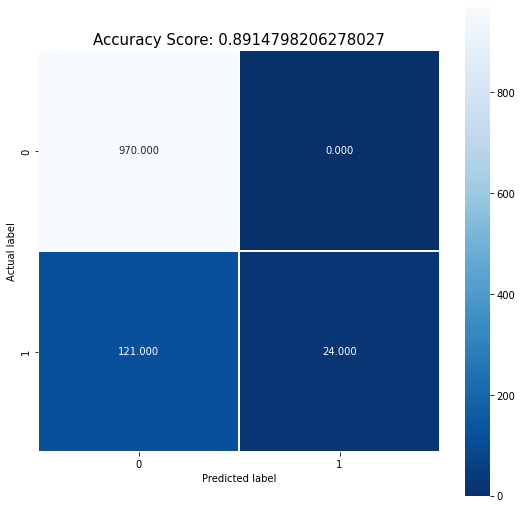

In [ ]:
evaluate_model(test_man_outputs,y_val,5,"MANHATTAN")

# ***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

Cosine similarity works the best with accuracy of 96%, recall of 75%, and precision of 98%. This means it predicts the spam emails 75% of the time and when it does predict an email as spam, it's correct 98% of the time. It works better than euclidean and manhattan because even if two similar documents are far apart in terms of distance (euclidean or manhattan) when one word appears much more in one document in one than the other - they might still have a smaller angle  between them representing higher the similarity. 

Cosine similarity is used to match similar documents and is advantageous over Euclidean for this application. As the size of each document increases, counting the max number of common words between documents doesn't work well since the number of common words increases even if the documents are about different topics. Its used as a distance metric mostly when the magnitude of the vector doesn't matter but its orientation. Cons is that magnitutde of the vectors is not taken into consideration at all. Cosine similarity also is less optimal in spaces of lower dimension and works best when there are many sparsely populated features.

Manhattan distance is used over Euclidean distance when there is high dimensionality of data. It also would be more useful than Euclidean distance when vectors describe objects on a uniform grid or if vectors are on an integer feature space. 

# ***3.Show confusion matrix, accuracy, recall, precision and F1-score. Why is accuracy alone is not sufficient to evaluate the model? Why do we need precision/recall/f1-score?***

Accuracy is not a very good score to evaluate the model when there is imbalanced data. For example if there are 95 positive labels for every 100 examples and your model has an accuracy of 95% this could be achieved by predicted the most common class value and doesn't say anything about the models predictions. Precision is the number of true postitives / (true positives + false positives) which tells how accurate the prediction is when a positive value is predicted. Recall is the number of true positives / (true postives + false negatives) which explains how often the model predicts the right positive label. Recall and precision have a tradeoff and when one gets better the other gets worse. F1 score is the harmonic mean of recall and precision and evaluates the model overall taking both into consideration.

# ***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 score vs k.***

In [91]:
all_neighbours = train_model(X_train, y_train, X_test, 5, distance="COSINE",check_hyper_parameters=True)

  0%|          | 0/1115 [00:00<?, ?it/s]

In [101]:
def check_hyperparameters(all_neighbours, x_test, y_test, k_values, distance="COSINE"):

  f1_scores = []

  for k in k_values:

    predicted = []

    for t_idx,t in enumerate(x_test):

      n = all_neighbours[t_idx][:k]
      if n.count(1) >= n.count(0): predicted.append(1)
      else: predicted.append(0)
    
    f1_scores.append(f1_score(y_test, predicted))

  # print(f1_scores)
  return f1_scores

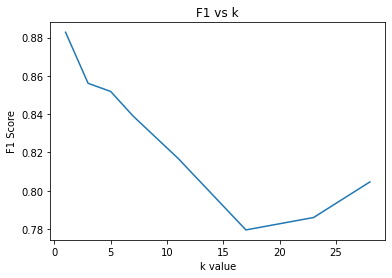

In [102]:
f1_scores = check_hyperparameters(all_neighbours, X_test, y_test, [1,3,5,7,11,17,23,28])

import matplotlib.pyplot as plt

plt.plot([1,3,5,7,11,17,23,28], f1_scores)
plt.title('F1 vs k')
plt.xlabel('k value')
plt.ylabel('F1 Score')
plt.show()

This plot shows that this model classifies emails as spam/ham best when it takes only the closest neighbour. The similarity between the closest neighbour and the test is the most, and this similarity drops as number of neighbours keep increasing. It then hits a threshold value beyond which a larger number of neighbours helps to improve the score since more examples are accounted for.

# ***Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
model.fit(X_train, y_train)

#Predict Output
predicted = model.predict(X_val)

For k=5 and similarity measure SKLEARN_CLASSIFIER
Accuracy score:  0.8869955156950673
F1 score:  0.23170731707317074
Precision score:  0.1310344827586207
Recall score:  1.0


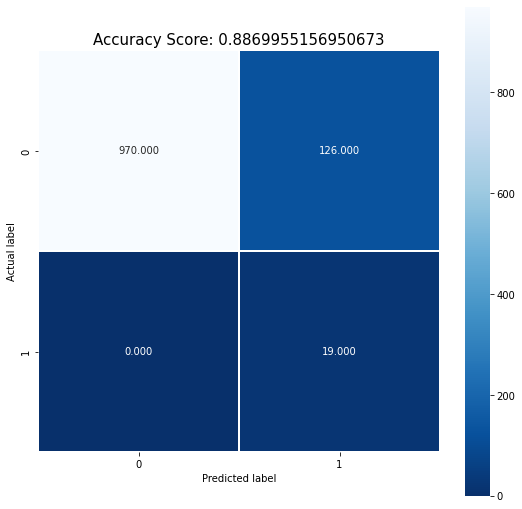

In [ ]:
evaluate_model(predicted,y_val,5,"SKLEARN_CLASSIFIER")

***Compare both the models result.***

My KNN Implementation: <br>
Accuracy score:  0.9668161434977578 <br>
F1 score:  0.8560311284046692 <br>
Precision score:  0.9821428571428571 <br>
Recall score:  0.7586206896551724 <br> <br> <br>


Sklean KNN Implementation: <br>
Accuracy score:  0.8869955156950673 <br>
F1 score:  0.23170731707317074 <br>
Precision score:  0.1310344827586207 <br>
Recall score:  1.0 <br>

The sklearn implementation took neglible time to run whereas my implementation took around 20 minutes for cosine similarity distance.

***What is the time complexity of training using KNN classifier?***

While training, time complexity is O(1). There is no algorithm run here, the features and target values are set.

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

While testing, time complexity is O(n + nlog(n)) = O(n), n being the number of training examples that each test features is compared with and then the training examples are sorted according to which are closest to the test example.

KNN is a non-linear classifier as you do not have a hyperplane (like in SVM) which classifies as positive or negative. A classifier is linear if its decision boundary on the feature space is a linear function. In KNN, the decision boundary is a curve around the training points. It can learn around non-linear boundaries too.